## Advanced Lane Finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [4]:
# Import require
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
%matplotlib inline

## Step 0. Load Images

In [5]:
# Load Calibration Images
cal_images = []
cal_images_f = glob.glob('./camera_cal/calibration*.jpg') # Load 20 given images
for file in cal_images_f:
    cal_images.append(mpimg.imread(file))

## Step 1. Camera Calibration
The first part of the project involved taking a set of chessboard images from the same camera used to record the road lanes, and use these images to calibrate the camera with OpenCV tools. The calibration was carried out as shown and suggested by the lesson. The output can be seen in the following cell. 

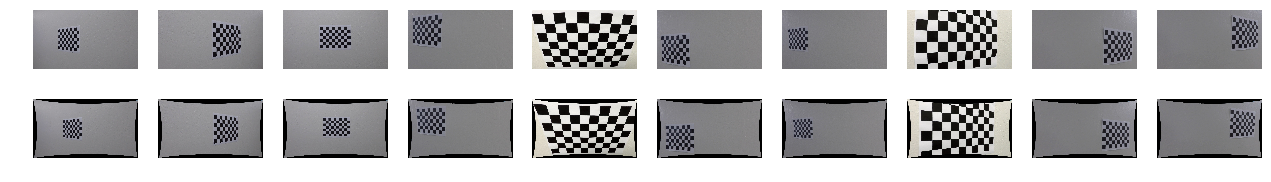

In [6]:
def calibrate_cam(cal_imgs):
    # Arrays to store object and image pts
    nx = 9
    ny = 6
    TestChessDraw = False
    obj_pts = []
    img_pts = []
    # Perpare object points
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    for img in cal_imgs:
        # convert to gray scale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
        
        #termination criteria
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        
        # Find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        # If corners found, add object points and and image points

        if ret == True:
            obj_pts.append(objp)
            #corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            img_pts.append(corners)

            # Test First Image
            if TestChessDraw == True:
                chess_test_img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                plt.imshow(chess_test_img)
                TestChessDraw = False
    # Get calibration parameters
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pts, img_pts, gray.shape[::-1], None, None)      
    return ret, mtx, dist, rvecs, tvecs
            
# Test calibration
_ , mtx, dist, _ , _ =  calibrate_cam(cal_images)

def undistort(img, mx = mtx , dis = dist):
    h,  w = img.shape[:2]
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mx,dis,(w,h),1,(w,h))
    return cv2.undistort(img, mx, dis, None, newcameramtx)

TestOnChessImages = True
if TestOnChessImages:
    # Check just ten images
    f, axarr = plt.subplots(2, 10, figsize =(22,3))
    for ind, image in enumerate(cal_images):
        axarr[0,ind].imshow(image)
        axarr[1,ind].imshow(undistort(image))
        axarr[0, ind].axis('off')
        axarr[1, ind].axis('off')
        if ind == 9:
            break

## Step 2. Undistort Images
The second step involved taking the camera calibration parameters and applying them to undistort the road images. The output of this function on the test images provided can be seen in the following cell.

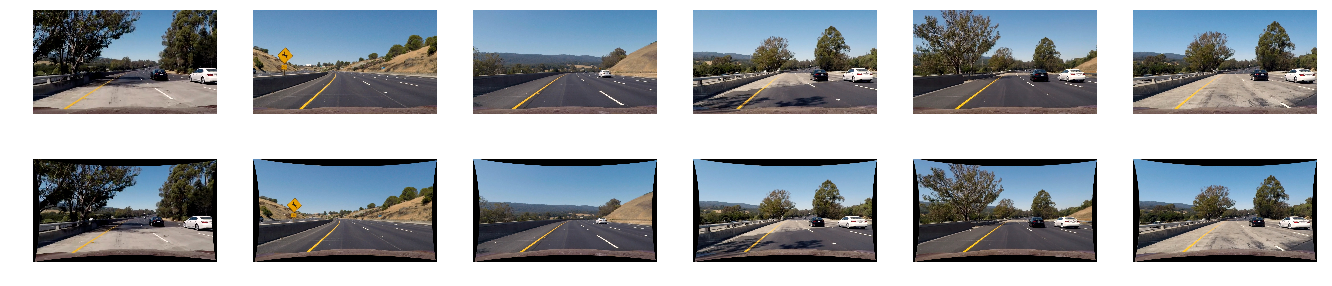

In [7]:
# Load Test Images
test_images = []
test_images_f = glob.glob('./test_images/test*.jpg')
for file in test_images_f:
    test_images.append(mpimg.imread(file))
    
TestOnImages = True
if TestOnImages:
    # Check just ten images
    f, axarr = plt.subplots(2, 6, figsize =(23,5))
    for ind, image in enumerate(test_images):
        axarr[0,ind].imshow(image)
        axarr[1,ind].imshow(undistort(image))
        axarr[0, ind].axis('off')
        axarr[1, ind].axis('off')

    

## Step 3. Color / Gradient Threshold
The following step involves a combination of color selection and apply a gradient threshold. Instead of simple image binarization, we use a combination of an HLS color conversion and channel selection and a number of Sobel gradient threshold. We first convert the image to HLS colorspace then choose the L and the S channels. The L channel is then used with Sobel gradients threshold including a across the x-direction, y-direction, and radial. The output of the latter is then combined again with the S channel imaged. The next cell includes the functions for these conversion, followed by a number of test cells.

In [8]:
def hls_select(img, chan = 's'):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if chan == 'h':
        channel = hls[:,:,0]
    elif chan == 'l':
        channel = hls[:,:,1]
    elif chan == 's':
        channel = hls[:,:,2]
    return channel

def hls_thresh(img, chan = 's', thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if chan == 'h':
        channel = hls[:,:,0]
    elif chan == 'l':
        channel = hls[:,:,1]
    elif chan == 's':
        channel = hls[:,:,2]
    hls_binary = np.zeros_like(channel)
    hls_binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return hls_binary

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255), convertGray = True):
    # Convert to grayscale
    if convertGray: 
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
    else:
        gray = img
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), convertGray = True):
    # Convert to grayscale
    if convertGray:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2), convertGray = True):
    # Grayscale
    if convertGray:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
    else:
        gray = img
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return dir_binary
        

A. Testing HLS Operators


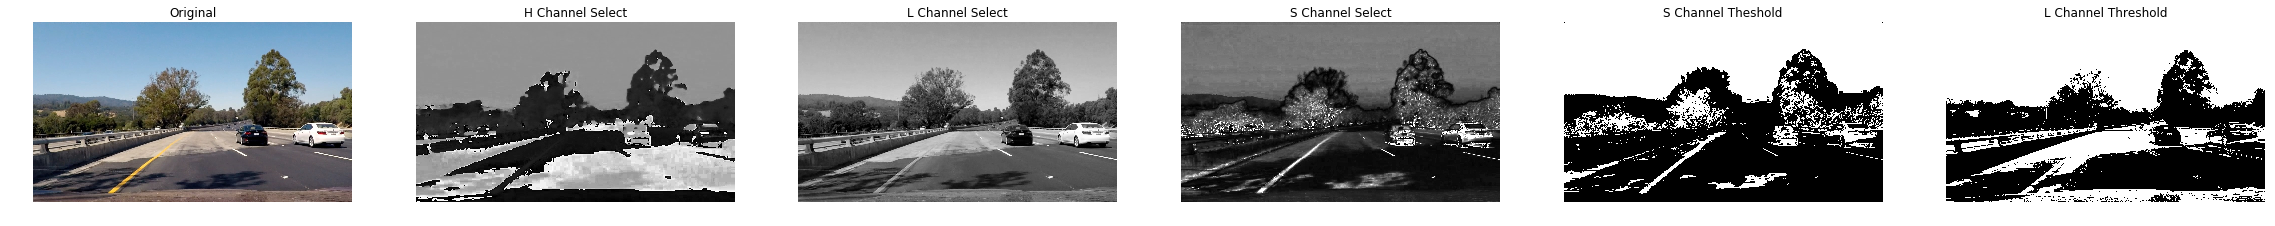

In [9]:
TestOnHLSImages = True
if TestOnHLSImages:

    HLSImages = []
    HLSImages.append(test_images[3])
    HLSImages.append(hls_select(HLSImages[0], chan = 'h'))
    HLSImages.append(hls_select(HLSImages[0], chan = 'l'))
    HLSImages.append(hls_select(HLSImages[0], chan = 's'))
    HLSImages.append(hls_thresh(HLSImages[0], chan = 's', thresh=(80,255)))
    HLSImages.append(hls_thresh(HLSImages[0], chan = 'l', thresh=(100,220)))

    # Check just ten images
    f, axarr = plt.subplots(1, 6, figsize =(40,10))
    print('A. Testing HLS Operators')
    titles = ['Original', 'H Channel Select', 'L Channel Select', 'S Channel Select', 'S Channel Theshold', 'L Channel Threshold']
    for ind, image in enumerate(HLSImages):
        axarr[ind].imshow(image, cmap = 'gray')
        axarr[ind].axis('off')
        axarr[ind].set_title(titles[ind])

B1. Testing Sobel Operators


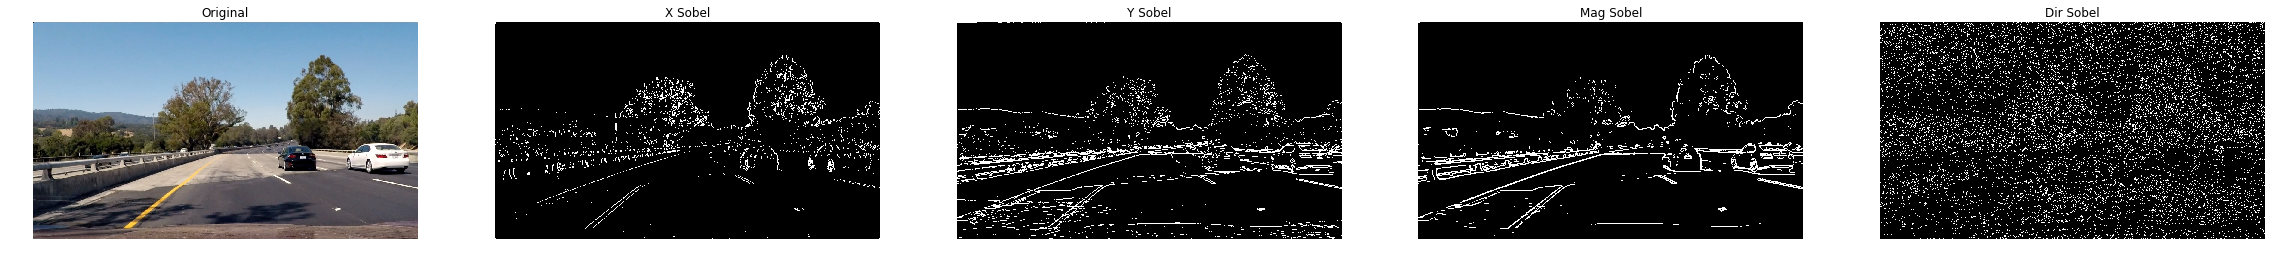

In [10]:
TestOnSobelImages = True
if TestOnSobelImages:
    print('B1. Testing Sobel Operators')
    titles = ['Original', 'X Sobel', 'Y Sobel', 'Mag Sobel', 'Dir Sobel']
    ksize = 11 # Choose a larger odd number to smooth gradient measurements
    SobelImages = []
    SobelImages.append(test_images[3])
    # Apply each of the thresholding functions
    SobelImages.append(abs_sobel_thresh(SobelImages[0], orient='x', sobel_kernel=ksize, thresh=(30, 200), convertGray = True))
    SobelImages.append(abs_sobel_thresh(SobelImages[0], orient='y', sobel_kernel=ksize, thresh=(30, 200), convertGray = True))
    SobelImages.append(mag_thresh(SobelImages[0], sobel_kernel=ksize, mag_thresh=(60, 200), convertGray = True))
    SobelImages.append(dir_threshold(SobelImages[0], sobel_kernel=ksize, thresh=(.5, .75), convertGray = True))
    # Check just ten images
    f, axarr = plt.subplots(1, 5, figsize =(40,10))
    for ind, image in enumerate(SobelImages):
        axarr[ind].imshow(image, cmap = 'gray')
        axarr[ind].axis('off')
        axarr[ind].set_title(titles[ind])

B1. Testing Sobel Operators with L channel select


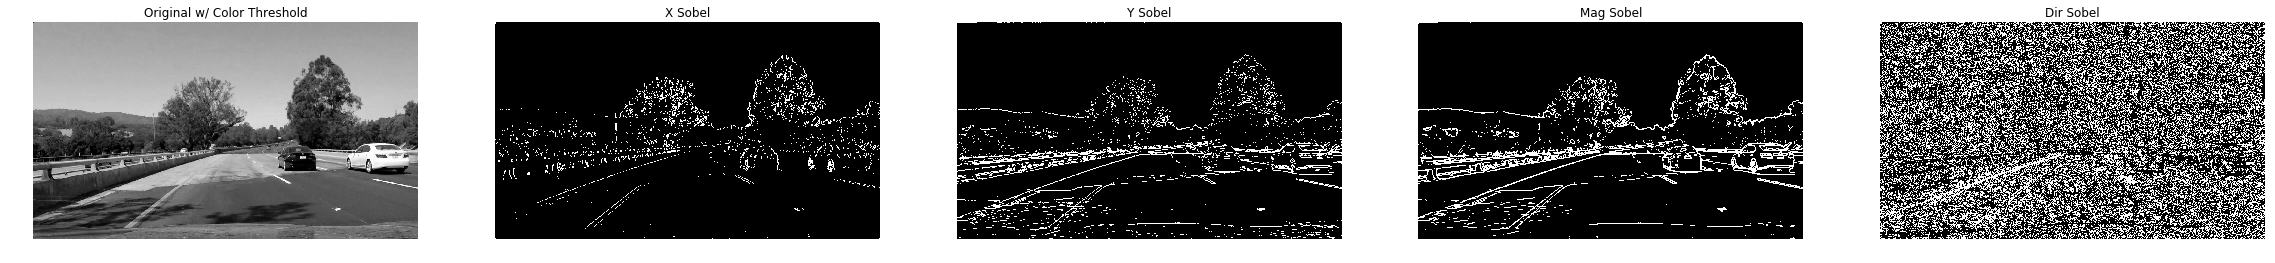

In [11]:
TestOnSobelImages = True
if TestOnSobelImages:
    print('B1. Testing Sobel Operators with L channel select')
    titles = ['Original w/ Color Threshold', 'X Sobel', 'Y Sobel', 'Mag Sobel', 'Dir Sobel']
    ksize = 7 # Choose a larger odd number to smooth gradient measurements
    SobelImages = []
    SobelImages.append(HLSImages[2])
    #SobelImages[0] = hls_thresh(SobelImages[0], chan = 's', thresh=(80,255))
    # Apply each of the thresholding functions
    SobelImages.append(abs_sobel_thresh(SobelImages[0], orient='x', sobel_kernel=ksize, thresh=(30, 200), convertGray = False))
    SobelImages.append(abs_sobel_thresh(SobelImages[0], orient='y', sobel_kernel=ksize, thresh=(30, 200), convertGray = False))
    SobelImages.append(mag_thresh(SobelImages[0], sobel_kernel=ksize, mag_thresh=(40, 255), convertGray = False))
    SobelImages.append(dir_threshold(SobelImages[0], sobel_kernel=ksize, thresh=(.8, np.pi/2 - .2), convertGray = False))
    # Check just ten images
    f, axarr = plt.subplots(1, 5, figsize =(40,10))
    for ind, image in enumerate(SobelImages):
        axarr[ind].imshow(image, cmap = 'gray')
        axarr[ind].axis('off')
        axarr[ind].set_title(titles[ind])

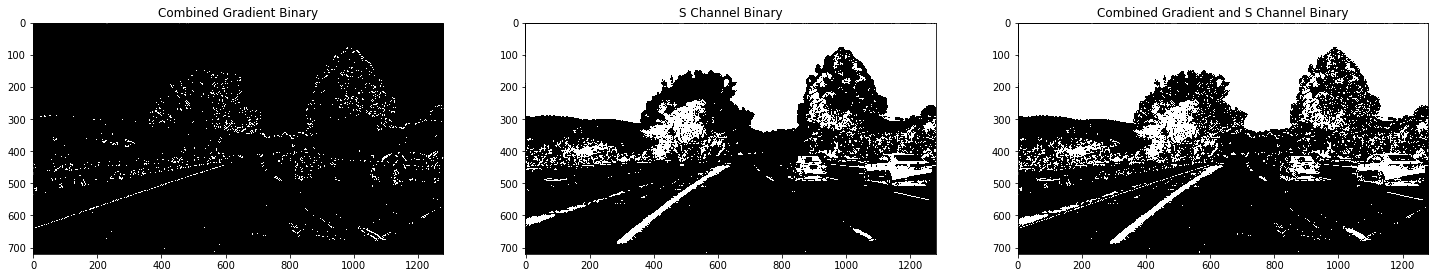

In [12]:
# Combining Color and gradient threshold
def CombinedThresh(imgRGB, visualize = True):
    imgLChannelG = hls_select(imgRGB, chan = 'l')
    imgSChannelB = hls_thresh(imgRGB, chan = 's', thresh=(80,255))
    imgSobelxB = abs_sobel_thresh(imgLChannelG, orient='x', sobel_kernel=ksize, thresh=(30, 200), convertGray = False)
    imgSobelyB = abs_sobel_thresh(imgLChannelG, orient='y', sobel_kernel=ksize, thresh=(30, 200), convertGray = False)
    imgSobelmB = mag_thresh(imgLChannelG, sobel_kernel=ksize, mag_thresh=(40, 255), convertGray = False)
    imgSobeldB = dir_threshold(imgLChannelG, sobel_kernel=ksize, thresh=(.7, np.pi/2-.4), convertGray = False)
    imgGradientB = np.zeros_like(imgSobeldB)
    imgGradientB[ (imgSobelxB == 1) & (imgSobelyB == 1) | (imgSobelmB == 1) & (imgSobeldB == 1)] = 1
    
    if visualize:
        f = plt.figure()
        f.set_figheight(15)
        f.set_figwidth(25)
        plt.subplot(1,3,1)
        plt.imshow(imgGradientB, cmap = 'gray')
        plt.title('Combined Gradient Binary')
        plt.subplot(1,3,2)
        plt.imshow(imgSChannelB, cmap = 'gray')
        plt.title('S Channel Binary')
    result = np.zeros_like(imgGradientB)
    result[(imgSChannelB == 1) | (imgGradientB == 1)] = 1
    if visualize:
        plt.subplot(1,3,3)
        plt.imshow(result, cmap = 'gray')
        plt.title('Combined Gradient and S Channel Binary')
    return result 

imgThresh = CombinedThresh(test_images[5])

## Step 4. Perspective Transformation
In the next step we performm a perspectivate transformation of our images in order to get a "top-view" of the road, this will allow us to estimate the road curvatery directly. We first define a trapeziodal region on a straight road segment, that when warped would result in a top-view straight parrallel lines. The wrap function performs this task. A test output can be seen in the following cell.

C. Testing Perspective Transformation


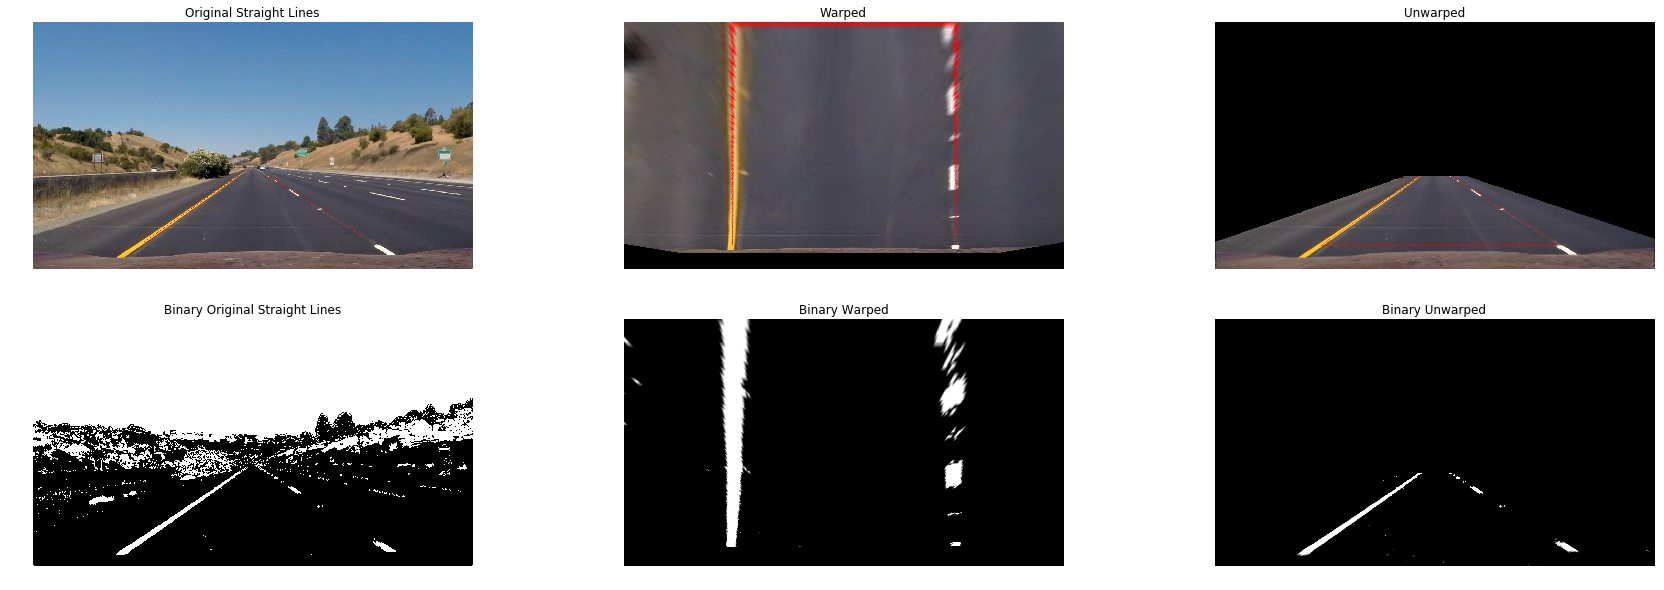

In [13]:
def wrap(img, src_cor, line_length, visualize = False, reverse = False):
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    d1 = ((img.shape[1] - line_length)/2, line_length)
    d2 = ((img.shape[1] - line_length)/2, 0)
    d3 = ((img.shape[1] + line_length)/2, 0)
    d4 = ((img.shape[1] + line_length)/2, line_length)
    src = np.array(src_cor, np.float32)
    dst = np.array([d1, d2, d3, d4], np.float32)
    #Calculate the Perspective Transformation Matrix

    if reverse:
        M = cv2.getPerspectiveTransform(dst, src)
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    else:
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    # Return the resulting image and matrix
    if visualize:
        plt.figure()
        plt.imshow(warped, cmap = 'gray')
        plt.title('Warped')
    return warped, M

HLSThresholdL = 60
HLSThresholdH = 255 
warpIMages =[]
warpIMages.append(mpimg.imread('./test_images/straight_lines1.jpg'))
warpIMages.append(CombinedThresh(warpIMages[0], visualize = False))

src_cor = ((310,650),(595,450),(687,450),(1000,650))
line_length = 650
cv2.line(warpIMages[0],src_cor[0],src_cor[1],(255,0,0),1)
cv2.line(warpIMages[0],src_cor[1],src_cor[2],(255,0,0),1)
cv2.line(warpIMages[0],src_cor[2],src_cor[3],(255,0,0),1)
cv2.line(warpIMages[0],src_cor[3],src_cor[0],(255,0,0),1)

print('C. Testing Perspective Transformation')
titles = ['Original Straight Lines','Binary Original Straight Lines', 'Warped', 'Binary Warped', 'Unwarped', 'Binary Unwarped']
wrapedImg, M = wrap(warpIMages[0], src_cor, line_length)
wrapedImgG, M = wrap(warpIMages[1], src_cor, line_length)
unwarpedImg, MT = wrap(wrapedImg, src_cor, line_length, reverse = True)
unwarpedImgG, MT = wrap(wrapedImgG, src_cor, line_length, reverse = True)
warpIMages.append(wrapedImg)
warpIMages.append(wrapedImgG)
warpIMages.append(unwarpedImg)
warpIMages.append(unwarpedImgG)
f, axarr = plt.subplots(2, 3, figsize =(30,10))
indices = ((0,0),(1,0),(0,1),(1,1), (0,2), (1,2))
for ind, image in enumerate(warpIMages):
    axarr[indices[ind]].imshow(image, cmap = 'gray')
    axarr[indices[ind]].axis('off')
    axarr[indices[ind]].set_title(titles[ind])

## Step 5. Detect Lane Lines
Once we have a properly transformed binary image into a top-view we can detect the lines and estimate the road curvature. We intially use a moving historgram window starting from the bottom of the image to find where the lines are and then incrementally move the histograms up the image to trace the the line. Once we have an initial estimate of the line position in the image we perform faster line tracking in the subsequent images. The following cell includes the implementation function for lane finding and lane tracking followed by a test on a sample image. 

In [14]:
def findLane(warpedImg, visualize = True):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warpedImg[int(warpedImg.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warpedImg, warpedImg, warpedImg))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warpedImg.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warpedImg.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warpedImg.shape[0] - (window+1)*window_height
        win_y_high = warpedImg.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    
    ploty = np.linspace(0, warpedImg.shape[0]-1, warpedImg.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    left_line_ptsC = np.stack((left_fitx,ploty), axis = -1)
    right_line_ptsC = np.stack((right_fitx,ploty), axis = -1)
    cv2.polylines(out_img,np.int_([left_line_ptsC]),True,(0,255,255))
    cv2.polylines(out_img,np.int_([right_line_ptsC]),True,(0,255,255))
    #result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if visualize:
        plt.figure()
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.title('Lane Finding')
    return out_img, left_fit, right_fit
    
def trackLane(img, left_fit, right_fit, visualize = True):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    left_line_pts, right_line_pts =  np.squeeze(left_line_pts), np.squeeze(right_line_pts)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    left_line_ptsC = np.stack((left_fitx,ploty), axis = -1)
    right_line_ptsC = np.stack((right_fitx,ploty), axis = -1)
    cv2.polylines(out_img,np.int_([left_line_ptsC]),True,(0,255,255))
    cv2.polylines(out_img,np.int_([right_line_ptsC]),True,(0,255,255))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #result = cv2.addWeighted(result, 1,  )
    if visualize:
        plt.figure()
        plt.imshow(result)
        plt.title('Lane Tracking')
    return result, left_line_ptsC, right_line_ptsC

(-0.5, 1279.5, 719.5, -0.5)

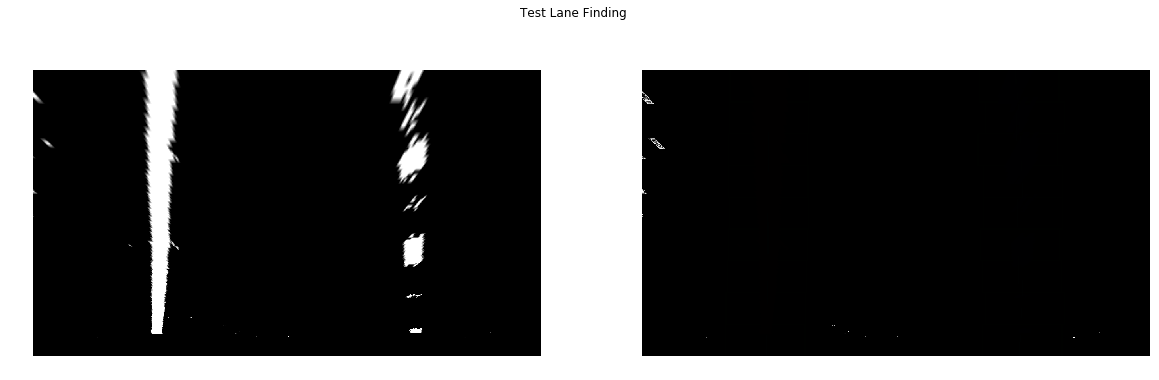

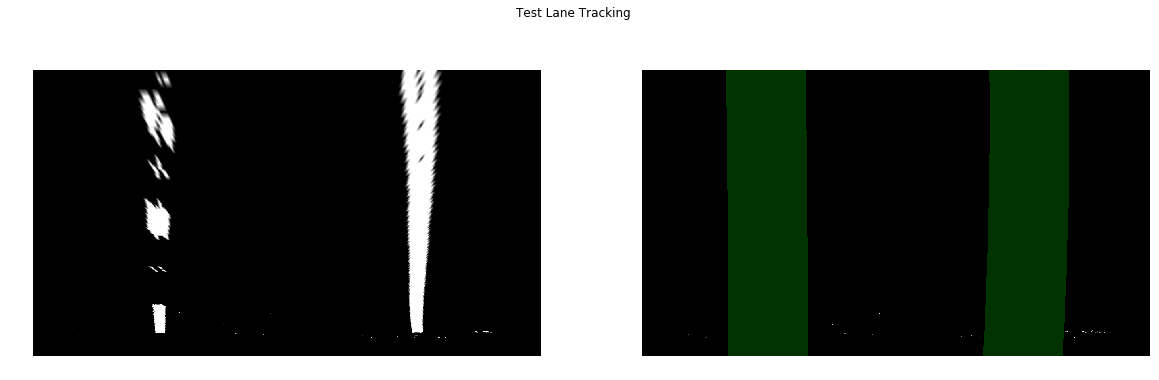

In [15]:
# Test Line Finding
def scale(im):
    rows,cols, ch = im.shape
    rpts = np.random.randint(-3,3)
    pts1 = np.float32([[rpts,rpts],[rows-rpts,rpts],[rpts,cols-rpts],[rows-rpts,cols-rpts]])
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    im = cv2.warpPerspective(im,M,(rows,cols))
    im = im[:,:,np.newaxis]
    return im
laneTestImage = mpimg.imread('./test_images/straight_lines1.jpg')
laneTestImage = CombinedThresh(laneTestImage, visualize = False)
laneTestImage, M = wrap(laneTestImage, src_cor, line_length)
laneImage, left_fit, right_fit = findLane(laneTestImage, visualize = False)
fig = plt.figure(figsize=(20, 6)) 
fig.suptitle('Test Lane Finding')
plt.subplot(1,2,1)
plt.imshow(laneTestImage, cmap ='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(laneImage)
plt.axis('off')

trackTestImage = mpimg.imread('./test_images/straight_lines2.jpg')
#Need to change the image a bit - randoml;y scale
#trackTestImage = scale(trackTestImage)
trackTestImageG = CombinedThresh(trackTestImage,  visualize = False)
trackTestImageG, M = wrap(trackTestImageG, src_cor, line_length)
trackTestImage, M = wrap(trackTestImage, src_cor, line_length)
trackResult, left_line_ptsC, right_line_ptsC = trackLane(trackTestImageG, left_fit, right_fit, visualize = False)
fig = plt.figure(figsize=(20, 6)) 
fig.suptitle('Test Lane Tracking')
plt.subplot(1,2,1)
plt.imshow(trackTestImageG, cmap ='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(trackResult, cmap = 'gray')
plt.axis('off')

## Step 6. Determine the Lane Curvature
The final core step in the image processing pipeline is to estimate the road curvature in world space along with the position of the vehicle on the road with respect to the center of the lane. The following cell includes the implementation function for calculating the road curvature and the vehicle position followed by a test on a sample image. 

In [42]:
def findCurve(img, left_line_ptsC, right_line_ptsC, visualize = True):
    ploty = left_line_ptsC[:,1]
    left_line_ptsCx = left_line_ptsC[:,0]
    right_line_ptsCx = right_line_ptsC[:,0]
    
    left_fit = np.polyfit(ploty, left_line_ptsCx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, right_line_ptsCx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    mark_size = 5
    
    if visualize:
        plt.figure()
        plt.imshow(img, cmap = 'gray')
        plt.plot(left_line_ptsCx, ploty, 'o', color='red', markersize=mark_size)
        plt.plot(right_line_ptsCx, ploty, 'o', color='blue', markersize=mark_size)
        plt.xlim(0, 1280)
        plt.ylim(0, 720)
        plt.plot(left_fitx, ploty, color='green', linewidth=3)
        plt.plot(right_fitx, ploty, color='green', linewidth=3)
        plt.gca().invert_yaxis() # to visualize as we do the images
        plt.title('Curve Fitting')
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curveradm = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curveradm = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    
    if visualize:
        print(left_curverad, right_curverad)
        print(left_curveradm, 'm', right_curveradm, 'm')
        
    return left_curveradm, right_curveradm

def findPosition(imgW, pts):
    pos = imgW /2
    left  = np.min(pts[(pts[:,1] < pos) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > pos) & (pts[:,0] > 700)][:,1])
    c = (left + right)/2
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    result = (pos - c) * xm_per_pix
    return result
    

27009.5438237 10762.1969224
8871.07173422 m 3518.63835914 m


(8871.0717342160824, 3518.6383591449394)

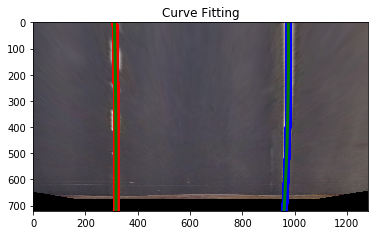

In [43]:
findCurve(trackTestImage, left_line_ptsC, right_line_ptsC)

# Step 7. Draw Lanes on Road
Once we trace the road lines, estimate the road curvature and the vehicle's relative position we can draw this information back on to the image frames then unwrap it into the perspective view image. This will result in a set of lines and drawn over the road lines, a polygonal shape in between and a text displaying the road curvature and the position of the vehicle. 

In [50]:
def drawLanes(imgUndistorted, imgBinaryWrapped, leftlane, rightlane, radius):
    # Draw Polygon within line area
    img = np.zeros_like(imgBinaryWrapped).astype(np.uint8)
    img = np.dstack((img, img, img))
    imgL = img
    ploty = leftlane.ally
    left_line_ptsCx = leftlane.bestx
    right_line_ptsCx = rightlane.bestx
    #print(type(left_line_ptsCx))
    #print(type(ploty))
    left_fit   = np.polyfit(ploty, left_line_ptsCx, 2)
    left_fitx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit  = np.polyfit(ploty, right_line_ptsCx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    pts_left   = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right  = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lane_pts= np.hstack((pts_left, pts_right))
    cv2.fillPoly(img, np.int_([lane_pts]), (255,255,200))
    # Unwarp 
    global src_cor, line_length
    unwarpedImgG, M = wrap(img, src_cor, line_length, reverse = True)
#     cv2.polylines(imgL,np.int_([leftlane.current_fit]), False,(255,0,0), 20)
#     cv2.polylines(imgL,np.int_([rightlane.current_fit]), False,(0,0,255), 20)
    cv2.polylines(imgL,np.int_([pts_left]), False,(255,0,0), 20)
    cv2.polylines(imgL,np.int_([pts_right]), False,(0,0,255), 20)
    unwarpedImgGL, M = wrap(imgL, src_cor, line_length, reverse = True)
    result = cv2.addWeighted(unwarpedImgGL, 1, unwarpedImgG, 0.2, 0.5)
    result = cv2.addWeighted(imgUndistorted, 1, result, .5, 0)
    # Draw Radius of Curvature Text on Image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(radius))
    cv2.putText(result,text,(350,100), font, 1,(255,255,200),2)
    
    # Find the position of the car
    pts = np.argwhere(unwarpedImgGL[:,:,1])
    pos = findPosition(unwarpedImgGL.shape[1],pts)
    if pos < 0:
        text = "Vehicle is {:.2f} m left of center".format(-pos)
    else:
        text = "Vehicle is {:.2f} m right of center".format(pos)
    cv2.putText(result,text,(350,150), font, 1,(255,255,200),2)
    
    f = plt.figure()
    f.set_figheight(15)
    f.set_figwidth(25)
    plt.imshow(result)
    return result
    # 
    

# Step 8. Combine into Pipeline
Now we combine the above steps into a single pipeline function that takes in a camera image frame, performs the following steps
1. Undistort
2. Binarize
3. Perspective Transform
4. Lane Finding / Tracking
5. Curvature and Position Estimation
6. Draw Information Back on Image

and for each iteration updates a the line information into a data class for each of the left and right lines. 
The following cell includes the implementation functions followed by a test on a sample image. 

In [51]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = -1 
        #average x values of the fitted line over the last n iterations
        self.bestx = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
def updateLanes(line, radius, lanefit):
    x = lanefit[:,0]
    line.ally = lanefit[:,1]   
    nAverage = 5 # Number of iterations to keep and average
    if line.detected: # If lane is detected in prior iteration
        if abs(radius / line.radius_of_curvature - 1) < .6:
            line.detected = True
            line.current_fit = lanefit
            line.allx = x
   
            line.radius_of_curvature = radius
        else:
            line.detected = False
            fitx = line.allx
    else: # If lane wasn't detected in prior iteration
        if line.radius_of_curvature: 
            if abs(radius / line.radius_of_curvature - 1) < 1:            
                line.detected = True
                line.current_fit = lanefit
                line.allx = x      
                line.radius_of_curvature = radius
            else:
                line.detected = False
                fitx = line.allx      
        else:
            line.detected = True
            line.current_fit = lanefit
            line.allx = x
            line.radius_of_curvature = radius
    
    # Average
    if np.all(line.recent_xfitted == -1):
        #print('new value')
        line.recent_xfitted = np.column_stack((x,x))
        line.bestx = x
    else:
        #print('updated value')
        #print(line.recent_xfitted.shape)
        #line.recent_xfitted = np.stack([line.recent_xfitted,x])
        line.recent_xfitted = np.column_stack((line.recent_xfitted,x))
        #print(line.recent_xfitted.shape)
        if (line.recent_xfitted).shape[1] > nAverage:
            line.recent_xfitted = np.delete(line.recent_xfitted, 0, 1)
        #print(np.size(line.recent_xfitted))
        line.bestx = np.mean(line.recent_xfitted, axis = 1)
    
    return line.bestx

def processframes(imgframe):
    global bootstrap
    global visualizeG
    global rightlane, leftlane
    titles = ['Original Frame','Undistorted', 'Binarized', 'Warped', 'Tracked Curve']
    if visualizeG:
        plt.figure()
        plt.imshow(imgframe)
        plt.title('Original Frame')
    # Undistort Image
    global mtx, dist
    imgUndistorted = undistort(imgframe, mx = mtx , dis = dist)
    if visualizeG:
        plt.figure()
        plt.imshow(imgUndistorted)
        plt.title('Undistorted')
# Binary Threshold 
    imgBinary = CombinedThresh(imgUndistorted, visualize = False)
    if visualizeG:
        plt.figure()
        plt.imshow(imgBinary, cmap  = 'gray')
        plt.title('Binarized')
    # Wrap image to get top view
    global src_cor, line_length
    imgBinaryWrapped, M = wrap(imgBinary, src_cor, line_length, visualizeG)
    #find line - bootstrap
    if bootstrap:
        laneImageOutputB, left_fit_, right_fit_ = findLane(imgBinaryWrapped, visualize =visualizeG)
        laneImageOutputN, left_fit, right_fit = trackLane(imgBinaryWrapped, left_fit_, right_fit_, visualize = visualizeG)
    else:
        try:
            left_fit
        except NameError:
            print('Run bootstrap lane finding first')
        else:
            laneImageOutputN, left_fit, right_fit = trackLane(imgBinaryWrapped, left_fit_, right_fit_, visualize = visualizeG)
            bootstrap = False 
    # Find Curve
    left_curveradm, right_curveradm = findCurve(laneImageOutputN, left_fit, right_fit, visualize = visualizeG)
    # Update Line Objects
    left_fit  = updateLanes(left_lane, left_curveradm, left_fit)
    right_fit = updateLanes(right_lane, right_curveradm, right_fit)
    # Draw lanes back on road 
    finalImage = drawLanes(imgUndistorted, imgBinaryWrapped, left_lane, right_lane, left_curveradm)
    return finalImage
            

E. Test Pipeline
3415.96301282 173342.84064
1018.04475444 m 45594.1850872 m


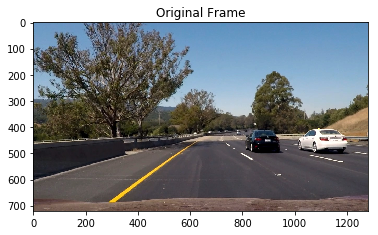

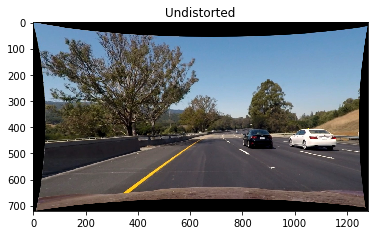

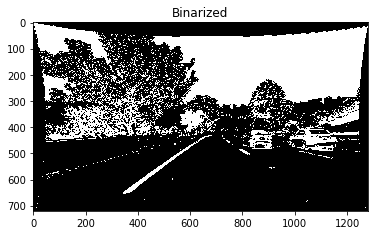

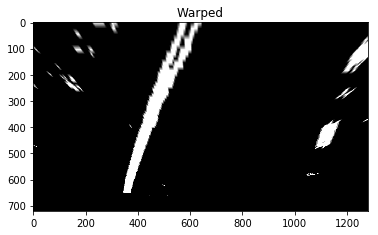

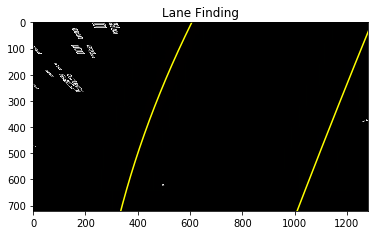

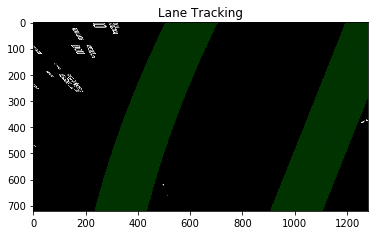

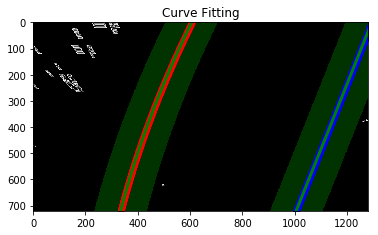

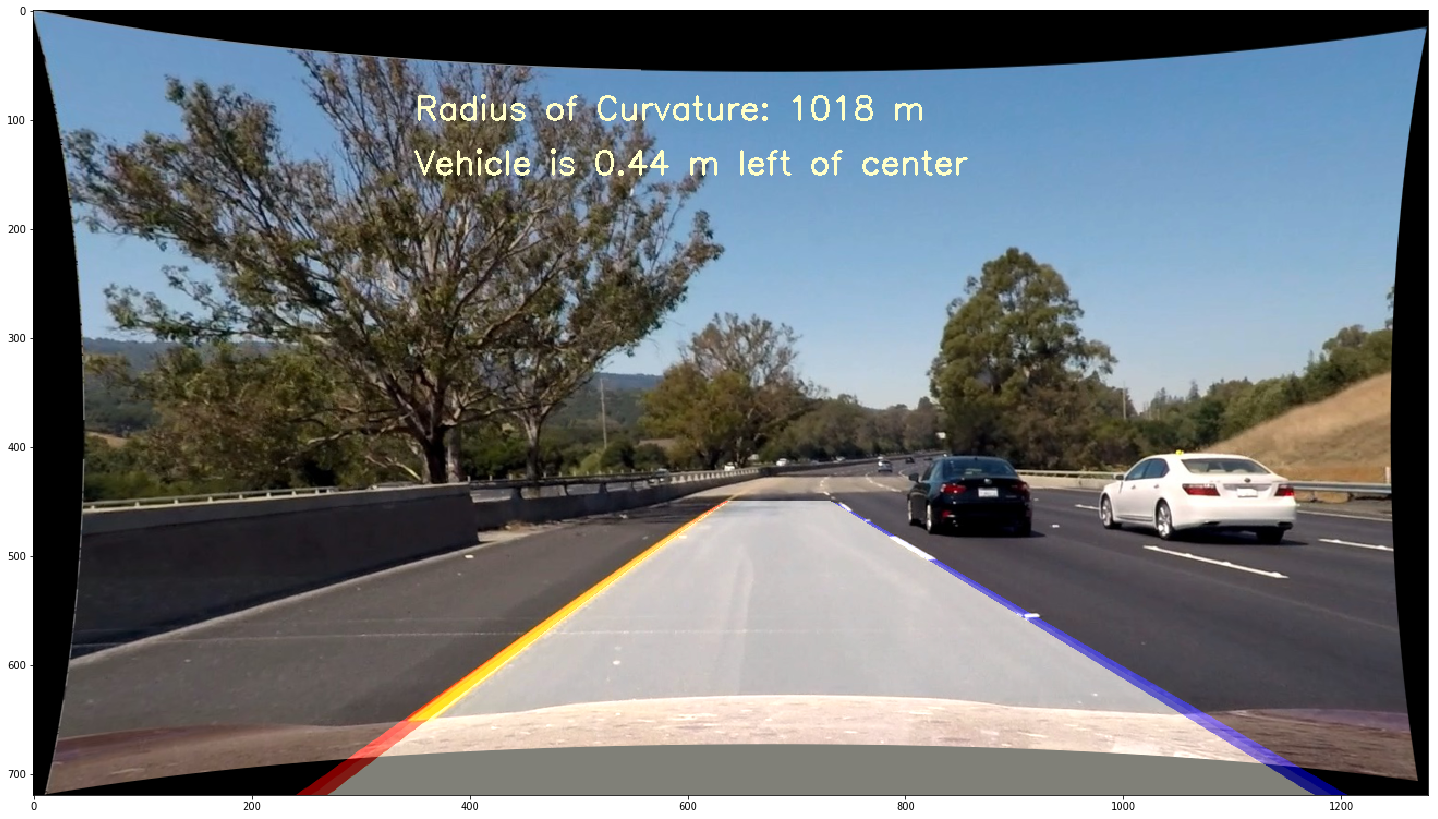

In [52]:
imgPipeTest = mpimg.imread('./test_images/test6.jpg')
print('E. Test Pipeline')
left_lane = Line()
right_lane = Line()
bootstrap = True
visualizeG = True
imgGG = processframes(imgPipeTest)

## Final Step. Run on video
Here we run the pipeline on the project video and save the output onto a new video. The output video can be found [here](https://github.com/alsaibie/UdacityCarND-AdvancedLaneFinding-P4/blob/master/project_output.mp4) "Project Output Video"

In [ ]:
# Import video packages
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Line class instances
left_lane = Line()
right_lane = Line()
bootstrap = True
visualizeG = False
project_output = 'ProjectOutput.mp4'
clip = VideoFileClip("project_video.mp4")
project_clip = clip.fl_image(processframes) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

## Conclusion
I found this project to be interesting and insightful. Performing a perspective transformation to a top-view is a neat a clever way to estimate the curvature of the road which can be then matched with a set of road maps along with a GPS position to narrow down the search. This can also be useful in poor GPS or GPS-denied environment to aid in localization and mapping. 

The lane tracking can be made more robust by employing a motion tracking filter, such as a Kalman Filter, to robustly keep "an eye" on the road lanes, and minimize erronous measurements especially when sudden environmental changes occur. 

An adaptive image binarization method can also be applied, or even a simple histogram equializtion can be performed to pick up the road markings. It was easy adjusting the binarization thresholds parameters to find the solid left lane, but it was much more tricky setting the thresholds right enough to get the dotted lines on the right. 

The road curvature also requires further tuning to get it right, the lines, even though they look stable in the image the still result in a highly varying road curvature, one that is unrealistic. A proper motion tracking filter can help narrow down the error covariance. 